In [1]:
import pyfesom2 as pf
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import cmocean.cm as cmo
from IPython.display import Image

osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.


# Transports in pyfesom2
This is the example notebook for computing cross-section transports from FESOM2 data.
Transport across meridional and zonal sections can be computed with the cross_section_transport.py function. Sections that are neither zonal or meridional are not yet supported. The velocity data is needed on elements (e.g. u.fesom.2000.nc, v.fesom.2000.nc).  
The computation is performed according to: Simple algorithms to compute meridional overturning and barotropic streamfunctions on unstructured meshes (Sidorenko et al., 2020)

### First, we need to load the mesh file and mesh_diag file

In [3]:
mesh = pf.load_mesh('/Users/fheukamp/Desktop/fesom2_test_year/')
mesh_diag = xr.open_dataset('/Users/fheukamp/Desktop/fesom2_test_year/fesom.mesh.diag.nc')

/Users/fheukamp/Desktop/fesom2_test_year/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /Users/fheukamp/Desktop/fesom2_test_year/pickle_mesh_py3_fesom2


### Let's compute the transport across the Barents Sea Opening...

In [4]:
transport, section = pf.cross_section_transport('BSO',                                                          # select a section from the presets or [lon1, lon2, lat1, lat2]
                                                mesh=mesh,                                                 # mesh
                                                data_path='/Users/fheukamp/Desktop/fesom2_test_year/',   # directory of the u, v, (T, S, uice, vice, m_ice, a_ice) files
                                                mesh_diag=mesh_diag,                                            # mesh_diag
                                                years=np.arange(2000,2001),                                     # years to compute
                                                use_great_circle=False,                                  # compute the section as a great circle
                                                how='ori',                                               # 'ori' do not apply mean, 'mean' apply time mean
                                                add_TS=True,                                            # add temperature and salinity to the section
                                                add_extent=1                                             # the extent to look for gridcells nerby the section, choose large for low resolutions
                                               )

[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  0.6s


### Take a look at the output...
Two outputs are returned by the function: an xr.Dataset containing the transport data and a dictionary containing informations on the section

#### The section dictionary contains information about the section: 
- start and end coordinates
- name of the section in case a preset is used
- orientation of the section
- whether a great circle was used or not
- the years that were computed
- the edge midpoints and element centers for each gridpoints that form the broken line across which the transport is computed

In [5]:
print(section['name'], ': Start: ', section['lon_start'], '°E ', section['lat_start'], '°N ', 'End: ', section['lon_end'], '°E ', section['lat_end'], '°N')

BSO : Start:  19.999 °E  74.5 °N  End:  19.999 °E  70.08 °N


#### The transport xr.Dataset containing the actual transport and additional data...

In [6]:
print(transport)

<xarray.Dataset>
Dimensions:                (nz1: 45, time: 12, elem: 199, triple: 3)
Coordinates:
  * nz1                    (nz1) float64 5.0 15.0 25.0 ... 5.525e+03 5.775e+03
  * time                   (time) datetime64[ns] 2000-01-31T23:55:00 ... 2000...
Dimensions without coordinates: elem, triple
Data variables: (12/13)
    elem_indices           (elem) int64 946703 946696 946693 ... 1068202 1068201
    elem_nods              (elem, triple) int64 481710 481711 ... 543004 543005
    zonal_distance         (elem) float64 -2.129e+03 431.3 ... -206.2 -571.7
    meridional_distance    (elem) float64 1.628e+03 2.669e+03 ... 2.425e+03
    vertical_cell_area_dx  (elem, nz1) float64 -2.129e+04 ... -1.429e+05
    vertical_cell_area_dy  (elem, nz1) float64 1.628e+04 1.628e+04 ... 6.062e+05
    ...                     ...
    lat_center             (elem) float64 70.13 70.16 70.18 ... 74.47 74.49
    u                      (time, elem, nz1) float64 0.02397 0.01915 ... -0.0
    v             

## Plot the results...


### First, define some plotting functions...

In [7]:
def PlotBackground(ax, section, closeup=False):
    
    ''''''
    gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color="gray",
    alpha=0.5,
    linestyle="--",
    x_inline=True,
    y_inline=False,
    zorder=20,
    )
    
    if closeup:
        ax.set_extent([19.8,20.1,73.5,73.7], crs=ccrs.PlateCarree())
    
        gl.xlocator = mticker.FixedLocator(
            [_ for _ in np.arange(19.8,20.05,.05)],
        )
        gl.ylocator = mticker.FixedLocator(np.arange(73.25,73.8,.05))
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    
    else:
        if section['name'] == 'BSO':
            ax.set_extent([18, 21, 69, 75], crs=ccrs.PlateCarree())

            gl.xlocator = mticker.FixedLocator(
                [_ for _ in np.arange(15,26,1)],
            )
            gl.ylocator = mticker.FixedLocator(np.arange(70,76,1))
            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER

        elif section['name'] == 'BSX':
            ax.set_extent([62, 66, 74, 82], crs=ccrs.PlateCarree())

            gl.xlocator = mticker.FixedLocator(
                [_ for _ in np.arange(62,65,1)],
            )
            gl.ylocator = mticker.FixedLocator(np.arange(60,85,1))
            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER


    ax.add_feature(cfeature.LAND, zorder=10, color='grey')

    gl.xlabel_style = {"size": 12, "rotation": 0}
    gl.ylabel_style = {"size": 12, "rotation": 0}
    

    
    

    return



def FindColorLevels(z, pcolor=True, div=True):
    '''
    '''
    min_lev = np.nanmin(z.flatten())
    max_lev = np.nanmax(z.flatten())
    
    if div:
        if np.abs(min_lev) > max_lev:
            if pcolor:
                levels=[-min_lev, min_lev]
            else:
                levels = np.arange(-min_lev, min_lev+min_lev/10, min_lev/10)

        elif np.abs(min_lev) < max_lev:
            if pcolor:
                levels=[-max_lev, max_lev]
            else:
                levels = np.arange(-max_lev, max_lev+max_lev/10, max_lev/10)
                
    else:
        levels = [min_lev, max_lev]
        
    return levels


def PlotSectionBirdview(transport, section, mesh):
    '''
    Plot the section from above
    '''
    
    # Set up figure 
    fig, ax = plt.subplots(1,1, figsize=(10,15), subplot_kw=dict(projection=ccrs.PlateCarree()))
    PlotBackground(ax, section)

    cb = ax.tripcolor(mesh.x2, mesh.y2, transport.elem_nods.values,transport.u.mean(dim=('time','nz1')), transform=ccrs.PlateCarree(), cmap='inferno', edgecolor='chartreuse')
    
    if section['orientation'] == 'meridional':
        ax.plot([section['lon_start'], section['lon_end']],[section['lat_start'], section['lat_end']], 'r-', transform=ccrs.PlateCarree())
    
    cbar = plt.colorbar(cb, ax=ax)
    cbar.set_label('depth averaged zonal velocity', fontsize=12)
    plt.show()
    return


def PlotDepthSection(transport, section, cmap='RdBu_r', unit='m/s', div=True, levels=None, ylim=(500,0)):
    '''
    Plot the depth section of the velocity on the original grid
    '''
    
    fig, ax = plt.subplots(1,1, figsize=(15,10))
    
    
    
    if section['orientation'] == 'meridional':
        if levels==None:
            levels = FindColorLevels(transport.u.mean(dim='time').values, pcolor=False, div=div)
            
        cb = ax.contourf(transport.lat_center, 
                    transport.nz1, 
                    transport.u.mean(dim='time').where(transport.u.mean(dim='time') != 0, np.nan).transpose(),
                    cmap=cmap, 
                    levels=levels
                   )
        
        cbar = plt.colorbar(cb,ax=ax, orientation='horizontal', shrink=.7)
        cbar.set_label('u ' + 'in ' + unit, fontsize=12)
        cbar.ax.tick_params(labelsize=12)
        ax.invert_yaxis()
        ax.set_ylim(ylim)
        ax.set_xlabel('latitude', fontsize=12)
        ax.set_ylabel('depth', fontsize=12)
        ax.tick_params(labelsize=12)
   
    if section['orientation'] == 'zonal':
        if levels==None:
            levels = FindColorLevels(transport.v.mean(dim='time').values, pcolor=False, div=div)
            
        cb = ax.contourf(transport.lon_center, 
                    transport.nz1, 
                    transport.v.mean(dim='time').where(transport.v.mean(dim='time') != 0, np.nan).transpose(),
                    cmap=cmap, 
                    levels=levels
                   )
        
        cbar = plt.colorbar(cb,ax=ax, orientation='horizontal', shrink=.7)
        cbar.set_label('v ' + 'in ' + unit, fontsize=12)
        cbar.ax.tick_params(labelsize=12)
        ax.invert_yaxis()
        ax.set_ylim(ylim)
        ax.set_xlabel('latitude', fontsize=12)
        ax.set_ylabel('depth', fontsize=12)
        ax.tick_params(labelsize=12)

    return 

### Let's take a look at the section from a birds perspective...

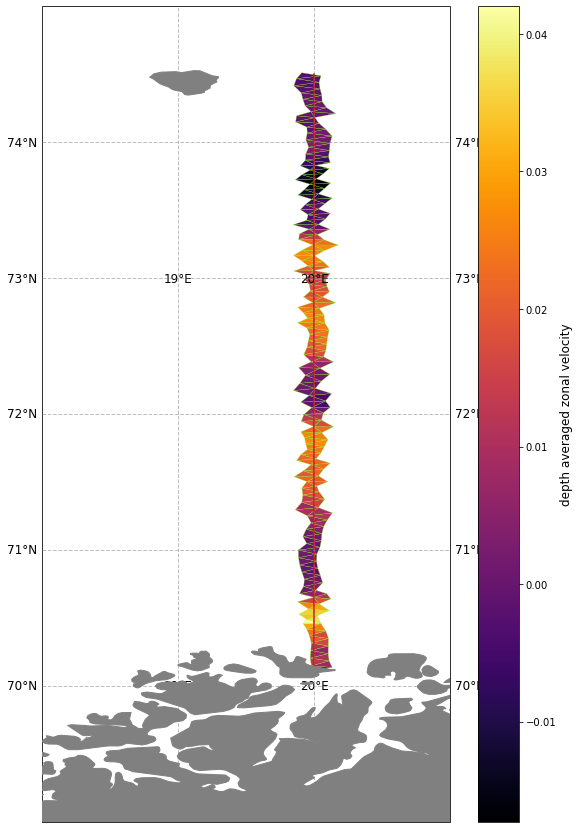

In [8]:
PlotSectionBirdview(transport, section, mesh)

### Look at a closeup of the section
The transport is computed across the red line, consisting of two line segments for each intersected mesh element that form the edge of the control volumes. Each elements two associated lines are expressed as vectors in local cartesian coordinates with repsect to their element center to compute the distances and finally the transports across.

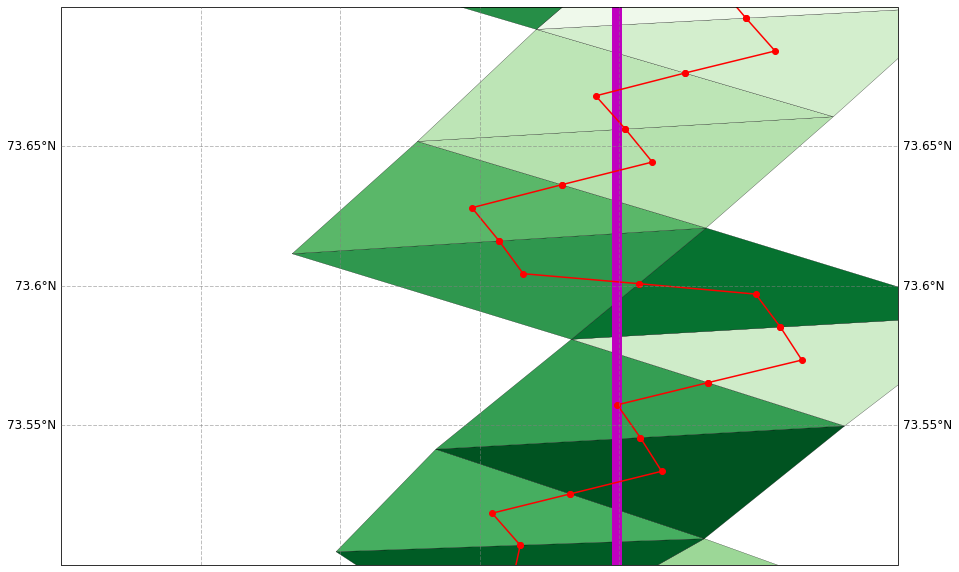

In [9]:
fig, ax = plt.subplots(1,1, figsize=(15,15), subplot_kw=dict(projection=ccrs.PlateCarree()))
PlotBackground(ax, section, closeup=True)

# Plot the mesh elements
ax.tripcolor(mesh.x2, mesh.y2, transport.elem_nods, np.random.rand(len(transport.elem_indices)), transform=ccrs.PlateCarree(), edgecolor='k', cmap='Greens')
# Plot the linear section
ax.plot([section['lon_start'],section['lon_end']],[section['lat_start'],section['lat_end']], 'm-', linewidth=10, transform=ccrs.PlateCarree())
# Plot the actual section
for i in range(len(section['f_lon'])):
    ax.plot([section['f_lon'][i],section['c_lon'][i],section['s_lon'][i]], [section['f_lat'][i],section['c_lat'][i],section['s_lat'][i]],'r-o', transform=ccrs.PlateCarree())
    

One problem to solve is the orientation of the vectors with respect to the magenta colored line which determines whether the transport is from left to right or right to left. To account for this the segment vectors are sorted from the southernmost (westernmost) edge intersection always pointing along the section. In this way it is possible to set up easy criteria to determine the sign of the transport. Each element has two vectors. Consider a positive meridional velocity: In the meridional case shown below, transport across the first vector (from south) will be from left to right, thus positive, as the x-component (dx) is negative. In case the x-component of an elements first vector is positive the transport will be from right to left of the section, thus negative. For the second vector of each element this relation is the same. In case of zonal sections the relation is inverted.

In [10]:
Image(url= "./images/section_vectors.png", width=1000, height=1000)

### We can plot data of the depth-section (the longitudes are the center longitudes of the intersected elements)


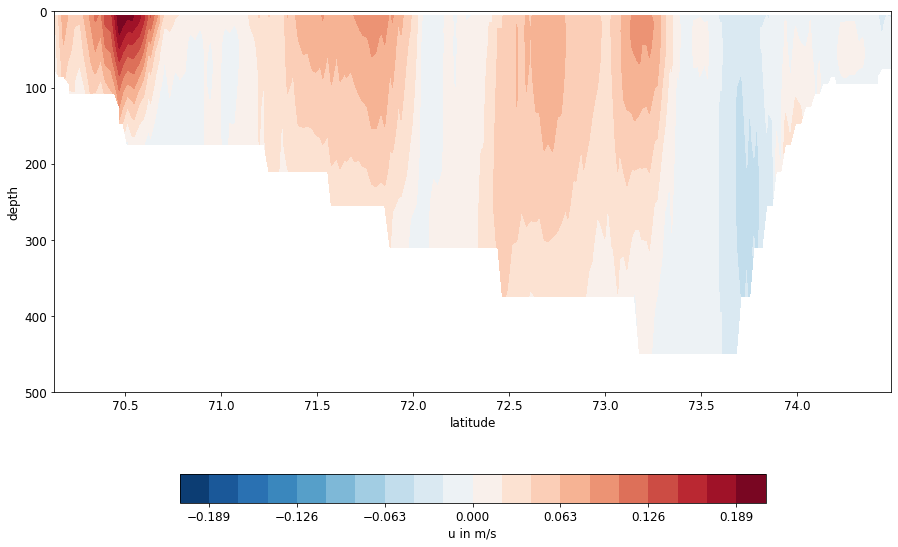

In [11]:
PlotDepthSection(transport, section, unit='m/s', cmap='RdBu_r')

### Now we compute the net transport across the section as a timeseries...
We make use of xarrays build in sum() functions to compute the transport across the section. To get the transport we sum up the single cell transports stored in transport.transport_across over the horizontal and vertical dimensions ('elem','nz1') and converting m3/s to Sverdrups

In [12]:
net_transport = transport.transport_across.sum(dim=('elem','nz1')) * 1e-6

We recieve an xarray.DataArray containing the transport that we can easily plot with xarrays build in plotting routines:

In [13]:
net_transport

<xarray.DataArray 'transport_across' (time: 12)>
array([5.62638636, 4.23931204, 3.85867177, 2.14590354, 2.68929302,
       1.59778308, 1.22180983, 2.07838459, 2.17468402, 2.91564502,
       3.04474258, 3.7151775 ])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-31T23:55:00 ... 2000-12-31T23:55:00

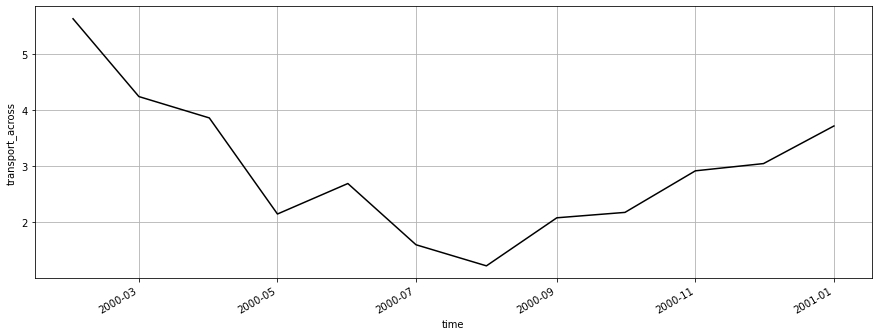

In [14]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.grid(':')

net_transport.plot(ax=ax, color='k')

### Add temperature/ salinity criteria to the transport...

When the add_TS=True salinity and temperature estimates are added to the dataset.  
From here it's easy to apply a temperature and/or salinity condition to compute only transports in specific TS ranges. For this we use the xarray.DataArray.where() function.   
Let's compute the warm/cold water transport, with water warmer/colder than 6°C. We set the transport in cells where the temperature is below/above 6°C to 0, so they do not contribute when we sum them up to recieve the total transport.

In [15]:
warm_water_transport = transport.transport_across.where(transport.temp > 6, 0).sum(dim=('elem','nz1')) * 1e-6
cold_water_transport = transport.transport_across.where(transport.temp <= 6, 0).sum(dim=('elem','nz1')) * 1e-6

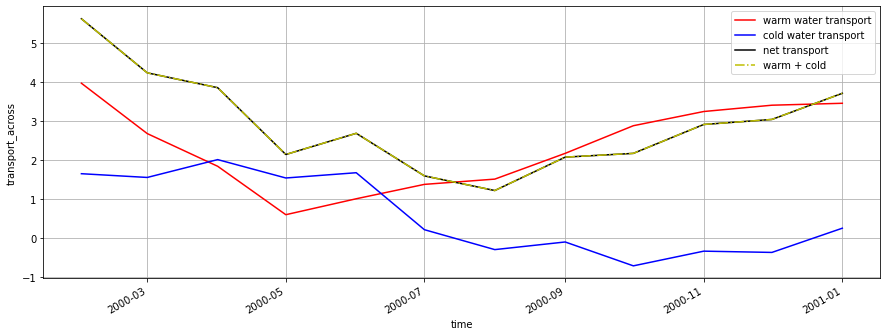

In [16]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.grid(':')

warm_water_transport.plot(ax=ax, color='r', label='warm water transport')
cold_water_transport.plot(ax=ax, color='b', label='cold water transport')
net_transport.plot(ax=ax, color='k', label='net transport')
(warm_water_transport + cold_water_transport).plot(ax=ax, color='y', linestyle='-.', label='warm + cold')

plt.legend()
plt.show()

## Consistency Check: Is the volume conserved?
To check this we compute the transport across a closed ring-section, we take 85°N.

In [17]:
transport_85N, section_85N = pf.cross_section_transport([-179.8, 180, 85, 85],                                                   # select a section from the presets or [lon1, lon2, lat1, lat2]
                                                mesh=mesh,            # mesh
                                                data_path='/Users/fheukamp/Desktop/fesom2_test_year/',   # directory of the u, v, (T, S, uice, vice, m_ice, a_ice) files
                                                mesh_diag=mesh_diag,                                            # mesh_diag_file
                                                years=np.arange(2000,2001),                                     # years to compute
                                                use_great_circle=False,                                  # compute the section as a great circle
                                                how='ori',                                               # 'ori' do not apply mean, 'mean' apply time mean
                                                add_TS=True,                                            # add temperature and salinity to the section
                                                add_extent=.075                                             # the extent to look for gridcells nearby the section, choose large for low resolutions
                                               )

/Users/fheukamp/Documents/Software/pyfesom2/pyfesom2/transport.py:243: UserWarning: The extend added to the box is small, this might lead to errors when using low resolution meshes
  warnings.warn(


[########################################] | 100% Completed |  3.8s
[########################################] | 100% Completed |  3.8s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.3s


### Let's plot the section...

/Users/fheukamp/miniconda3/envs/pyfesom2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:842: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/Users/fheukamp/miniconda3/envs/pyfesom2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:853: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:
/Users/fheukamp/miniconda3/envs/pyfesom2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:848: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], i

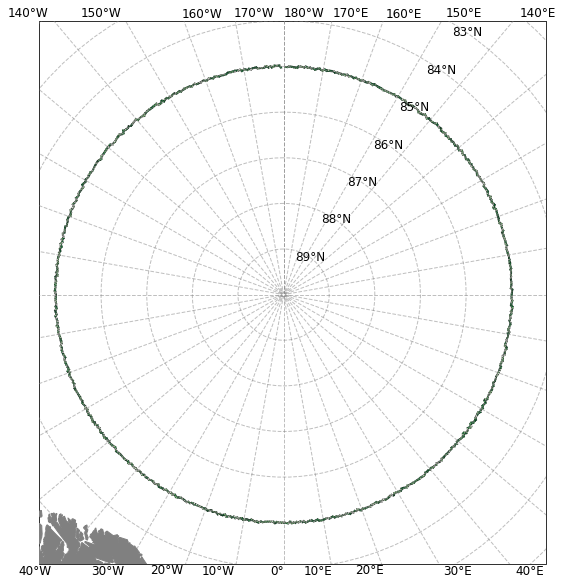

In [18]:
fig, ax = plt.subplots(1,1,figsize=(10,10), subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
 
gl = ax.gridlines(
crs=ccrs.PlateCarree(),
draw_labels=True,
linewidth=1,
color="gray",
alpha=0.5,
linestyle="--",
x_inline=False,
y_inline=True,
zorder=20,
)

ax.set_extent([-180, 180, 84, 90], crs=ccrs.PlateCarree())

gl.xlocator = mticker.FixedLocator([_ for _ in np.arange(-180,190,10)])
gl.ylocator = mticker.FixedLocator([_ for _ in np.arange(-90,91,1)])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.add_feature(cfeature.LAND, zorder=10, color='grey')

gl.xlabel_style = {"size": 12, "rotation": 0}
gl.ylabel_style = {"size": 12, "rotation": 0}

# Plot the mesh elements
ax.tripcolor(mesh.x2, mesh.y2, transport_85N.elem_nods, np.random.rand(len(transport_85N.elem_indices)), transform=ccrs.PlateCarree(), edgecolor='k', cmap='Greens')
plt.show()

### Now compute the net transport...
Currently, the ring is not perfectly closed at 180°E due to limitations in the software. However, a few missing gridcells in this high resolution should only result in a small error and the net transport should be close to 0Sv. 

In [19]:
net_transport_85N = transport_85N.transport_across.sum(dim=('elem','nz1')).mean(dim='time') * 1e-6
print( 'The annual mean net transport across the section is: ' + str(net_transport_85N.values) + 'Sv')

The annual mean net transport across the section is: 0.006531802819489661Sv
